### Consensus

In [4]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')

suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
quantDir <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=1.4:2.8/post_type=gibbs_nrep=100_tf=100/salmon_quants"
saveDir <- "environment/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees_updated_sim"
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep="_")))
                           
files <- file.path(quantDir, samples, "quant.sf")
coldata <- data.frame(files = files, names = samples, condition = as.factor(rep(c(1,2),each=6)))
clustFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=1.4:2.8/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold0/cluster_nwk.txt"
tseCons <- buildTSE(treeTermFile = clustFile, coldata = coldata)
treeCons <- rowTree(tseCons)
l <- length(treeCons$tip)

termFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=1.4:2.8/post_type=gibbs_nrep=100_tf=100/terminus/old/1_1/clusters.txt"

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3911

Aggregation Started

Aggregation Ended



In [5]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
# load(file.path(saveDir, "tAfterBHMoreClimbMIRVUp.RData"))
# load(file.path(saveDir, "treeDEFDR.RData"))
# load(file.path(saveDir, "treeDEFDR_OL.RData"))
load(file.path(saveDir, "bouthBrain.RData"))
load(file.path(saveDir, "bSwishCons.RData"))

In [3]:
which(bouthBrain[[1]][["results.by.node"]][["is.driver"]])
which(bouthBrain[[2]][["results.by.node"]][["is.driver"]])
which(bouthBrain[[3]][["results.by.node"]][["is.driver"]])

[1] 1

[1] 1

[1] 1

In [6]:
load("/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=1.4:2.8/sim_expr.rda")
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))

missingTxps <- setdiff(treeCons$tip.label, rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[treeCons$tip.label,]
dts <- intersect(dts, rownames(sim.counts.mat))

innNodes <- l+1:treeCons$Nnode
aggCountsNodes <- computeAggNodesU(treeCons, c(1:length(treeCons$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])

In [5]:
mean(abs(logFCNodes[setdiff(seq(l),match(dts, names(logFCNodes)))])>rootFC)

[1] 0

In [6]:
rootFC

Node138328 
0.01270263

In [11]:
y <- fishpond::scaleInfReps(tseCons[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y, x="condition")

#### Terminus

In [7]:
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseCons[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
yAggTermThrNS <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yAggTermThrNS)
yTerm <- labelKeep(yTerm)
set.seed(10)
yTerm <- swish(yTerm, x="condition")

In [8]:
aggCountsNodes <- computeOAggNodesU(groupsClust, mInds, sim.counts.mat)
logFCNodesTerm <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))

#### Gene Level

In [9]:
gse <- summarizeToGene(tseCons[1:l,])
gy <- fishpond::scaleInfReps(gse)
set.seed(10)
gy <- labelKeep(gy)
gy <- swish(gy, x="condition")

loading existing TxDb created: 2023-03-02 17:08:07

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-03-02 17:08:18

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [12]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["treeDEFDR_OL"]] <- lapply(treeDEFDR_OL[["mIRV=0.4"]], function(ta) ta)
detNodes[["treeClimbR"]] <- lapply(bSwish, function(sw) sw$output[sw$output$signal.node,][["node"]])
detNodes[["treeClimbRO"]] <- lapply(bSwish, function(sw) unlist(Descendants(treeCons,sw$output[sw$output$signal.node,][["node"]])))

negNodes <- list()
negNodes[["Txps"]] <- lapply(detNodes[["Txps"]], function(nodes) setdiff(seq(l), nodes))
negNodes[["treeDEFDR_OL"]] <- lapply(detNodes[["treeDEFDR_OL"]], function(nodes) setdiff(seq(nrow(y)), unlist(Descendants(treeCons, nodes))))
negNodes[["treeClimbR"]] <- lapply(detNodes[["treeClimbR"]], function(det) setdiff(seq(nrow(y)), unlist(Descendants(treeCons, det))))
negNodes[["treeClimbRO"]] <- lapply(detNodes[["treeClimbRO"]], function(det) setdiff(seq(nrow(y)), det))

In [13]:
df <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{    
    print(n)
    if(!n %in% c("term", 'genes')) {
        stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], logFCNodes, tree = tree, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))
        for(i in seq(ncol(stats)))
            stats[,i] <- round(unlist(stats[,i]),3)                 
        colnames(stats) <- colnames(df)[c(3:5)]
        stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
        df <- rbind(df, stats)
    }

}
print(df)

[1] "Txps"
[1] "tp 0.992961559285328"
[1] "tp 0.957336780866193"
[1] "tp 0.919309100283578"
[1] "treeDEFDR_OL"
[1] "tp 0.9931650893796"
[1] "tp 0.951822916666667"
[1] "tp 0.911987464089841"
[1] "treeClimbR"
[1] "tp 0.992805755395683"
[1] "tp 0.958300857365549"
[1] "tp 0.917063222297757"
[1] "treeClimbRO"
[1] "tp 0.934312878133103"
[1] "tp 0.888772845953003"
[1] "tp 0.804462180301106"
           Method Metric FDR_0.01 FDR_0.05 FDR_0.10
fdr          Txps    FDR    0.007    0.043    0.081
tpr          Txps    TPR    0.209    0.337    0.406
fdr1 treeDEFDR_OL    FDR    0.007    0.048    0.088
tpr1 treeDEFDR_OL    TPR    0.244    0.382    0.458
fdr2   treeClimbR    FDR    0.007    0.042    0.083
tpr2   treeClimbR    TPR      0.2    0.314    0.383
fdr3  treeClimbRO    FDR    0.066    0.111    0.196
tpr3  treeClimbRO    TPR    0.246    0.388    0.505


In [14]:
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(logFCNodesTerm))
    })
negNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[setdiff(seq(nrow(yTerm)),
                                                 which(mcols(yTerm)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodesTerm))
    })
stats <-  sapply(seq_along(detNodes[["term"]]), function(i) computeMetOut(detNodes[["term"]][[i]], 
                                                                          logFCNodesTerm, tree = NULL, 
                                                                          negNodes = negNodes[["term"]][[i]],
                                                                          lfcThresh = rootFC))
for(i in seq(ncol(stats)))
    stats[,i] <- round(unlist(stats[,i]),3)                 
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("term",2), Metric = c("FDR", "TPR"), stats)
df <- rbind(df, stats)

[1] "tp 0.992708917554683"
[1] "tp 0.959641255605381"
[1] "tp 0.924517752306402"


In [14]:
df

,Method,Metric,FDR_0.01,FDR_0.05,FDR_0.10
,<named list>,<named list>,<named list>,<named list>,<named list>
fdr,Txps,FDR,0.007,0.043,0.081
tpr,Txps,TPR,0.209,0.337,0.406
fdr1,treeDEFDR_OL,FDR,0.007,0.048,0.088
tpr1,treeDEFDR_OL,TPR,0.244,0.382,0.458
fdr2,treeClimbR,FDR,0.007,0.042,0.083
tpr2,treeClimbR,TPR,0.2,0.314,0.383
fdr3,treeClimbRO,FDR,0.066,0.111,0.196
tpr3,treeClimbRO,TPR,0.246,0.388,0.505
fdr4,term,FDR,0.007,0.04,0.075


In [15]:
detNodes[["genes"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(gy)[,"qvalue"] <= x ))
negNodes[["genes"]] <- lapply(detNodes[["Genes"]], function(nodes) setdiff(seq(nrow(gy)), nodes))
dg <- union(dge.genes, dte.genes)
length(dg)
mean(dg %in% rownames(gse))
dg <- intersect(dg, rownames(gse))
length(dg)
tG <- match(dg, rownames(gse))
                              
stats <- sapply(detNodes[["genes"]], function(genes) {
    computeTPFP(tG, genes, seq(nrow(gse)), seq(nrow(gse)))
})
for(i in seq(ncol(stats)))
    stats[,i] <- round(unlist(stats[,i]),3)
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("genes",2), Metric = c("FDR", "TPR"), stats)
df <- rbind(df, stats)
df

[1] 4150

[1] 0.9862651

[1] 4093

,Method,Metric,FDR_0.01,FDR_0.05,FDR_0.10
,<named list>,<named list>,<named list>,<named list>,<named list>
fdr,Txps,FDR,0.007,0.043,0.081
tpr,Txps,TPR,0.209,0.337,0.406
fdr1,treeDEFDR_OL,FDR,0.007,0.048,0.088
tpr1,treeDEFDR_OL,TPR,0.244,0.382,0.458
fdr2,treeClimbR,FDR,0.007,0.042,0.083
tpr2,treeClimbR,TPR,0.2,0.314,0.383
fdr3,treeClimbRO,FDR,0.066,0.111,0.196
tpr3,treeClimbRO,TPR,0.246,0.388,0.505
fdr4,term,FDR,0.007,0.04,0.075


In [26]:
dN <- detNodes[["term"]][[3]]

termTxps <- c(names(logFCNodesTerm)[dN][startsWith(names(logFCNodesTerm)[dN], "ENS")],
  names(logFCNodesTerm)[as.numeric(unlist(groupsClust[names(logFCNodesTerm)[dN][!startsWith(names(logFCNodesTerm)[dN], "ENS")]]))])

length(termTxps)
length(unique(termTxps))

[1] 4608

[1] 4608

In [10]:
treeDETxps <- rownames(tseCons)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[3]]))]
treeClimbTxps <- rownames(tseCons)[unlist(Descendants(treeCons, detNodes[["treeClimbR"]][[3]]))]

In [16]:
suppressPackageStartupMessages(library(tidyr))
dfA <- df %>% pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
dfA

Method,FDR_0.01_FDR,FDR_0.05_FDR,FDR_0.10_FDR,FDR_0.01_TPR,FDR_0.05_TPR,FDR_0.10_TPR
<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>
Txps,0.007,0.043,0.081,0.209,0.337,0.406
treeDEFDR_OL,0.007,0.048,0.088,0.244,0.382,0.458
treeClimbR,0.007,0.042,0.083,0.2,0.314,0.383
treeClimbRO,0.066,0.111,0.196,0.246,0.388,0.505
term,0.007,0.04,0.075,0.218,0.342,0.407
genes,0.007,0.042,0.075,0.334,0.448,0.509


In [18]:
save(detNodes, file = "treeDE_Paper/brain_sim_notdu_lowfc/detNodes.RData")
save(negNodes, file = "treeDE_Paper/brain_sim_notdu_lowfc/negNodes.RData")
save(dfA, file = "treeDE_Paper/brain_sim_notdu_lowfc/dfA.RData")

In [19]:
dfA %>% gather(FDR)

Method,FDR_0.01_FDR,FDR_0.05_FDR,FDR_0.10_FDR,FDR_0.01_TPR,FDR_0.05_TPR,FDR_0.10_TPR
<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>
Txps,0.007,0.043,0.081,0.209,0.337,0.406
treeDEFDR_OL,0.007,0.048,0.088,0.244,0.382,0.458
treeClimbR,0.007,0.042,0.083,0.2,0.314,0.383
treeClimbRO,0.066,0.111,0.196,0.246,0.388,0.505
term,0.007,0.04,0.075,0.218,0.342,0.407
genes,0.007,0.042,0.075,0.334,0.448,0.509


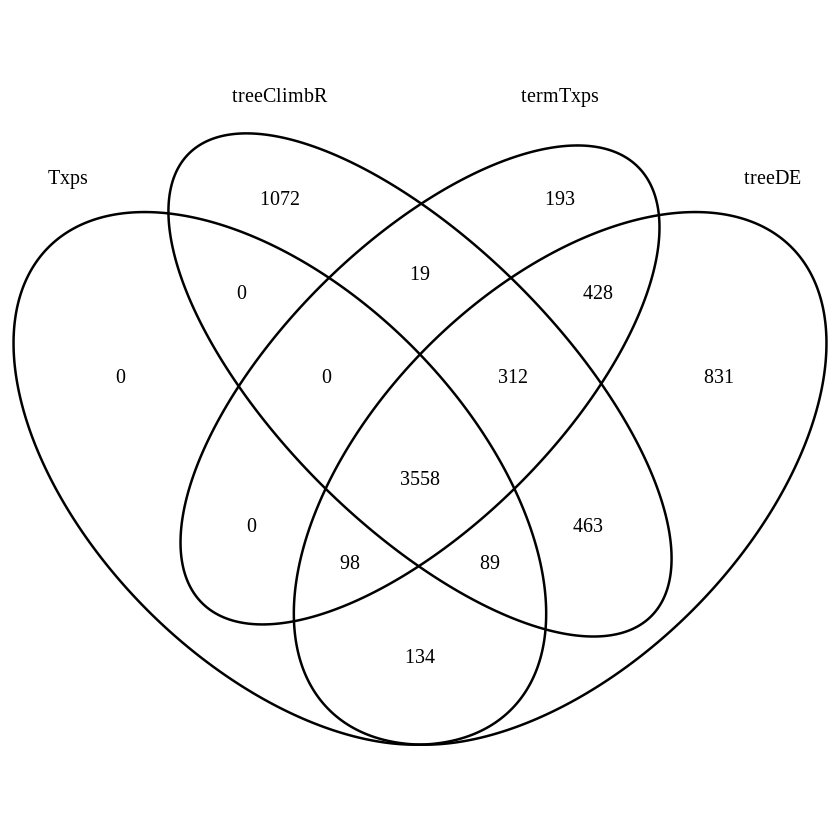

In [27]:
library(VennDiagram)
ve <- venn.diagram(
  x = list(Txps = rownames(tseCons)[detNodes[[1]][[3]]], treeDE = treeDETxps, treeClimbR = treeClimbTxps, term = termTxps),
  category.names = c("Txps", "treeDE", "treeClimbR", "termTxps"),
  filename = NULL  # Specify the output file name
)
grid.draw(ve)

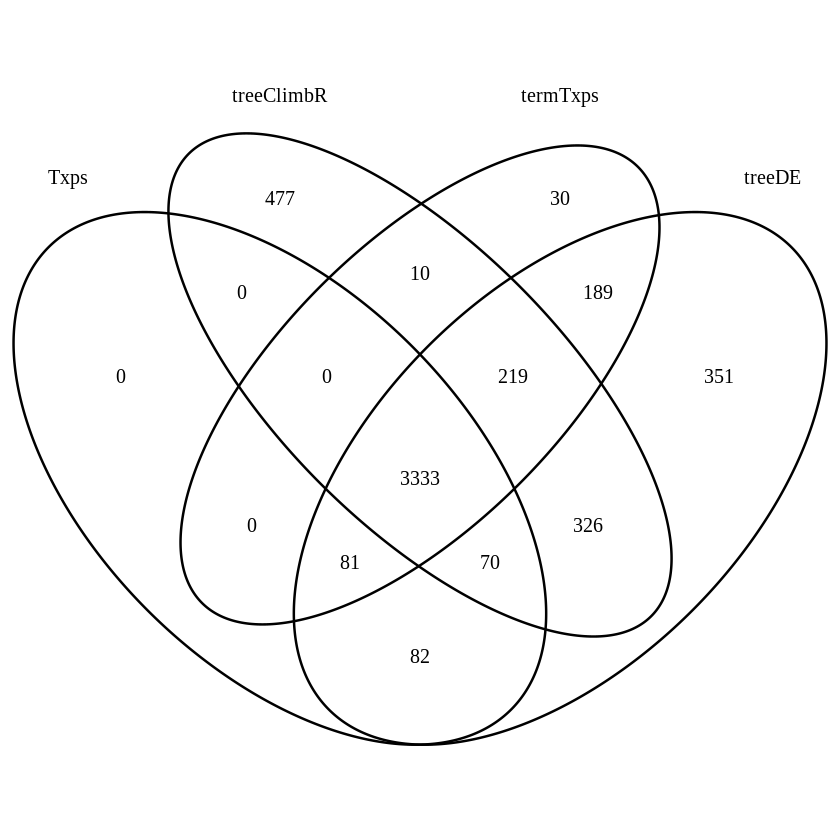

In [28]:
library(VennDiagram)
ve2 <- venn.diagram(
  x = lapply(list(Txps = rownames(tseCons)[detNodes[[1]][[3]]], 
           treeDE = treeDETxps,
           treeClimbR = treeClimbTxps,
           term = termTxps), function(x) intersect(x, dts)),
      category.names = c("Txps", "treeDE", "treeClimbR", "termTxps"),
      filename = NULL  # Specify the output file name
)
grid.draw(ve2)

##### FDR at leaf and transcript level

In [30]:
i <- 1
n <- "treeClimbR"
sum(detNodes[[n]][[i]] > l)
iNodes <- detNodes[[n]][[i]][detNodes[[n]][[i]] > l]
mean(abs(logFCNodes[iNodes]) <= rootFC)

sum(detNodes[[n]][[i]] <= l)
lNodes <- detNodes[[n]][[i]][detNodes[[n]][[i]] <= l]
mean(abs(logFCNodes[lNodes]) <= rootFC)

[1] 322

[1] 0

[1] 1346

[1] 0.008915305

In [46]:
tail(names(logFCNodesTerm))
tail(detNodes[["term"]][[3]])

[1] "143779" "143780" "143781" "143782" "143783" "143784"

[1] 143750 143757 143759 143766 143777 143782

In [ ]:
library(VennDiagram)
txps <- list()
for(n in names(detNodes)[c(1,2)])

#### Transcripts unique to treeDE

In [ ]:
i <- 3
uniTreeDEFDR <- setdiff(unlist(Descendants(treeCons,detNodes[["treeDEFDR_OL"]][[i]])), detNodes[["Txps"]][[i]])
uniTreeDEFDRTP <- uniTreeDEFDR[abs(logFCNodes[uniTreeDEFDRTP]) > rootFC]
length(uniTree)

In [33]:
install.packages("VennDiagram")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [32]:
missP <- setdiff(unlist(Descendants(treeCons,detNodes[[""]][[2]])), detNodes[[1]][[2]])
missTP <- missP[abs(logFCNodes[missP]) > rootFC] ##True positive transcripts that have an internal node
length(missP)
length(missTP)
# missInTreeDE <- setdiff(detNodes[[1]][[2]], unlist(Descendants(tree,detNodes[[3]][[2]])))
# missTPInTreeDE <- missInTreeDE[abs(logFCNodes[missInTreeDE]) > rootFC] ##True positive transcripts that have an internal node
# sum(unique(unlist(Ancestors(tree, missTP))) %in% detNodes[[3]][[2]]) ### Nodes of these additional ancestors 

[1] 0

[1] 0

In [14]:
missP <- setdiff(unlist(Descendants(tree,detNodes[["treeDEFDR_OL"]][[2]])), detNodes[[1]][[2]])

In [15]:
length(missP)
length(missTP)
length(missInTreeDE)
length(missTPInTreeDE)

[1] 2219

[1] 790

[1] 284

[1] 204

In [16]:
dd <- sapply(Descendants(tree, detInnerNodes[[2]]), function(nodes) {
    if(length(nodes) > 1) {
        all(abs(logFCNodes)[nodes] > rootFC) & (sum(nodes %in% detNodes[[1]][[2]])==0)
    }
})

In [26]:
mcols(y)[Descendants(tree, detInnerNodes[[2]])[[146]],]

DataFrame with 2 rows and 8 columns
                  meanInfRV log10mean      keep      stat    log2FC     pvalue
                  <numeric> <numeric> <logical> <numeric> <numeric>  <numeric>
ENST00000508457.1   3.14153   1.63351      TRUE    -13.90  -1.00361 0.00815617
ENST00000379205.4   3.06227   1.65498      TRUE    -13.01  -0.90171 0.01409578
                     locfdr    qvalue
                  <numeric> <numeric>
ENST00000508457.1  0.517371 0.0744448
ENST00000379205.4  0.686017 0.1185206

In [81]:
detInnerNodes <- sapply(detNodes[["tAfterBHMoreClimbMIRV=0.4"]], function(nodes) nodes[nodes > l])
sapply(detInnerNodes, length)
sapply(seq_along(detInnerNodes), function(i) mean(abs(logFCNodes[detInnerNodes[[i]]]) < rootFC))

[1] 1122 1200 1251

[1] 0.01158645 0.05916667 0.10471623

In [78]:
tAfterBHMoreClimbMIRV[[1]] <- lapply(tAfterBHMoreClimbMIRV[[1]], function(nodes) nodes[!is.na(nodes)])
tAfterBHMoreClimbMIRV[[2]] <- lapply(tAfterBHMoreClimbMIRV[[2]], function(nodes) nodes[!is.na(nodes)])
tAfterBHMoreClimbMIRV[[3]] <- lapply(tAfterBHMoreClimbMIRV[[3]], function(nodes) nodes[!is.na(nodes)])

In [82]:
missP <- setdiff(unlist(Descendants(tree,detNodes[[3]][[2]])), detNodes[[1]][[2]])
missTP <- missP[abs(logFCNodes[missP]) > rootFC] ##True positive transcripts that have an internal node

missInTreeDE <- setdiff(detNodes[[1]][[2]], unlist(Descendants(tree,detNodes[[3]][[2]])))
missTPInTreeDE <- missInTreeDE[abs(logFCNodes[missInTreeDE]) > rootFC] ##True positive transcripts that have an internal node

sum(unique(unlist(Ancestors(tree, missTP))) %in% detNodes[[3]][[2]]) ### Nodes of these additional ancestors 
length(missP)
length(missTP)
length(missInTreeDE)
length(missTPInTreeDE)

[1] 548

[1] 2204

[1] 789

[1] 194

[1] 135